In [23]:
#python v3.11.3

import warnings
#to suppress seaborn palette warnings
warnings.filterwarnings("ignore", category=UserWarning)
#to suppress seaborn error estimation NaN warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)



import os
import datetime

import numpy as np #v1.25.0
import pandas as pd #v2.0.3
import scipy #v1.10.1
import scipy.stats as stats

import seaborn as sns #v0.13.0
import matplotlib as mpl #v3.8.1
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

#import matplotlib.spines as spines
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection


# these files should be in the same directory as this Jupyter notebook
from loader import *
from analysis_functions import *
from plot_functions import *

# to set styles for plotting
mpl.style.use(r"C:\Users\swind\Documents\lab_work\Barth\behavior_analysis\mouse_analysis\full_trial_analysis\mouse_analysis.mplstyle")

#to suppress inaccurate pandas reassignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

# 1. Load Files

### Parameters

In [8]:
# directory files are pulled from
csv_directory = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\mouse_analysis\\full_trial_analysis\\sample_data'

# file containing information about animals (cage, age, sex, strain) - must have Animal ID column
metadata_file = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\mouse_analysis\\full_trial_analysis\\sample_metadata.xlsx'

mins = {
        "min_trials": 0,  # minimum number of trials in a bin to keep
        "min_blank": 0,   # minimum number of water trials
        "min_stimulus": 0 # minimum number of water trials 
        }

keys = {
    "millis bin":"puff delta",
    "Time (ms)":"Time (ms)",
    "stimulus type":"stimulus",
    "water delivery":"water",
    "trial no":"trial no",
    "time bin":"delta",
    "licks":"lick",
    "timestamp":"timestamp",
    "delay":"delay",
    "acc":"acc",
    'offset':'offset'
}

index = ["condition", "animal"]
values = ["lick", "poke"]

### 1.1 Load metadata file

The metadata file allows data from multiple animals with different acclimation 
times to be loaded together. Optional columns will label each animal with that 
information and allow splitting data based on those properties. Add any columns
that should be kept to the `keep` list. All column names are case sensitive.

Required columns:
- column named `Animal ID`
    - this ID must match folder names or lookup will not work
- column named `acc`
    - number of days the animal was acclimated
    - this is for alignment of the data, and must be based on the start date of 
    the first file
        - for example, if an animal only has SAT data but was acclimated for 2 
        days, and the first behavior file is dated to the start of SAT, the
        animal should be marked as having been acclimated for 0 days
    - if lookup fails, the code will exit

Example optional columns:
- column named `Age` (optional)
    - age of animal
- column named `Sex` (optional)
    - sex of animal
- column named `Cage` (optional)
    - cage animal was trained in
- column named `Strain` (optional)
    - animal strain
- etc.

Other columns present in the metadata file and will be ignored.

In [9]:
metadata = pd.read_excel(metadata_file)
keep = ["Age", "Sex", "Strain", "acc", "Cage"]

### 1.2 Load data

In [15]:
# this will load all conditions in a directory of multiple conditions
df = []
for d in os.listdir(csv_directory):
    cond = make_condition_df(csv_directory +'\\' + d, d, metadata, keep)
    df.append(cond)
df = pd.concat(df)
keep = keep + ['stimulus', 'water', 'type']

# 2. Lick Frequency Analysis

All plotting is done using a combination of the
`seaborn` and `matplotlib` modules.

Parameters

In [16]:
time_bin = 4*60 # minutes

min_trials = 10 # minimum number of trials in a bin to keep
min_water_trials = 0 # minimum number of water trials
min_blank_trials = 0 # minimum number of water trials

## 2.1 Anticipatory licking



### 2.1.1 Analysis

The range `r` is inclusive on both sides.

In [32]:
r = (700, 1000)
keys["millis bin"] = None
mins["min_trials"] = 10 # minimum number of trials in a bin to keep
mins["min_blank"] = 1 # minimum number of water trials
mins["min_stimulus"] = 1 # minimum number of water trials


ant_data = bin_lickfreq(df, r, time_bin, keys, keep, values)
antkeep = keep + ["Time (hr)", "delta", "Day", "day_delta"]
ant_data_filtered = drop_group(ant_data, mins, keys, "trial no", index, antkeep)


Index(['condition', 'animal', 'trial no', 'lick', 'poke', 'Age', 'Sex',
       'Strain', 'acc', 'Cage', 'stimulus', 'water', 'type', 'timestamp',
       'first sample', 'offset'],
      dtype='object')


In [33]:
keys["time bin"] = "delta"
keys["millis bin"] = None
ant_mean_statistics, counts, ant_perf  = agg(ant_data_filtered, keys, index, antkeep, values)
total_by_day = sum_trials(counts, index + ["Day"], keep,"trial no")
total_by_hour = sum_trials(counts, index + ["Time (hr)"], keep,"trial no")

In [34]:
parts = 5 # number of partitions to divide each day's trials into 
nth_part = 5 # which partition of trials to get (1-indexed)
keys["time bin"] = "day_delta"
keys['millis bin'] = None

nth_part_data = get_nth_part_day(ant_data_filtered, parts, nth_part)
nthpart_lickfreq, nthpart_counts, nthpart_perf = agg(nth_part_data, keys, index, antkeep, values)

### 2.1.2 Animal N's

Number of animals with data per timebin

In [24]:
num_per_timebin = counts.groupby(["condition", "animal", "Time (hr)"]).first().reset_index().groupby(["condition","Time (hr)"])["animal"].count().reset_index()
num_per_timebin.set_index(["condition", "Time (hr)"]).unstack("Time (hr)")

animal                                                              \
Time (hr)  -48.0 -44.0 -40.0 -36.0 -32.0 -28.0 -24.0 -20.0 -16.0 -12.0 -8.0    
condition                                                                      
ACC3         1.0   1.0   1.0   1.0   1.0   1.0   NaN   1.0   1.0   1.0   1.0   
SAT1         2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   
psSAT1       1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

                                                           
Time (hr) -4.0   0.0   4.0   8.0   12.0  16.0  20.0  24.0  
condition                                                  
ACC3        1.0   1.0   1.0   1.0   1.0   1.0   1.0   NaN  
SAT1        1.0   1.0   2.0   2.0   2.0   2.0   NaN   1.0  
psSAT1      1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0

Total number of animals per condition

In [25]:
num_per_timebin.groupby("condition")["animal"].max()

condition
ACC3      1
SAT1      2
psSAT1    1
Name: animal, dtype: int64

### 2.1.3 Plotting

Lick frequency for stimulus and blank trials

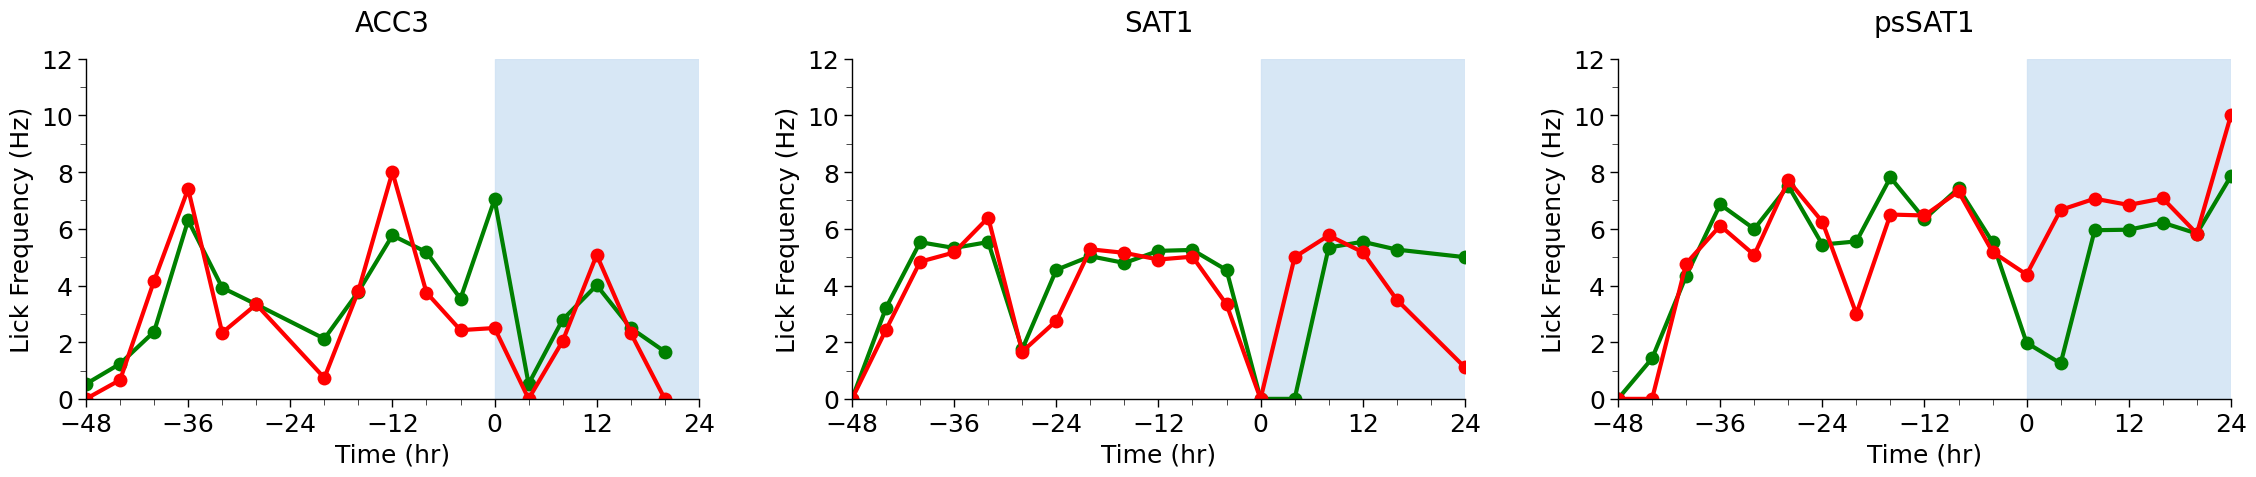

In [26]:
plot_ant_lickfreq(ant_mean_statistics, legend=False)

Separating the four types of trials for pseudotraining: no water & blank, 
no water & stimulus, water & blank, water & stimulus

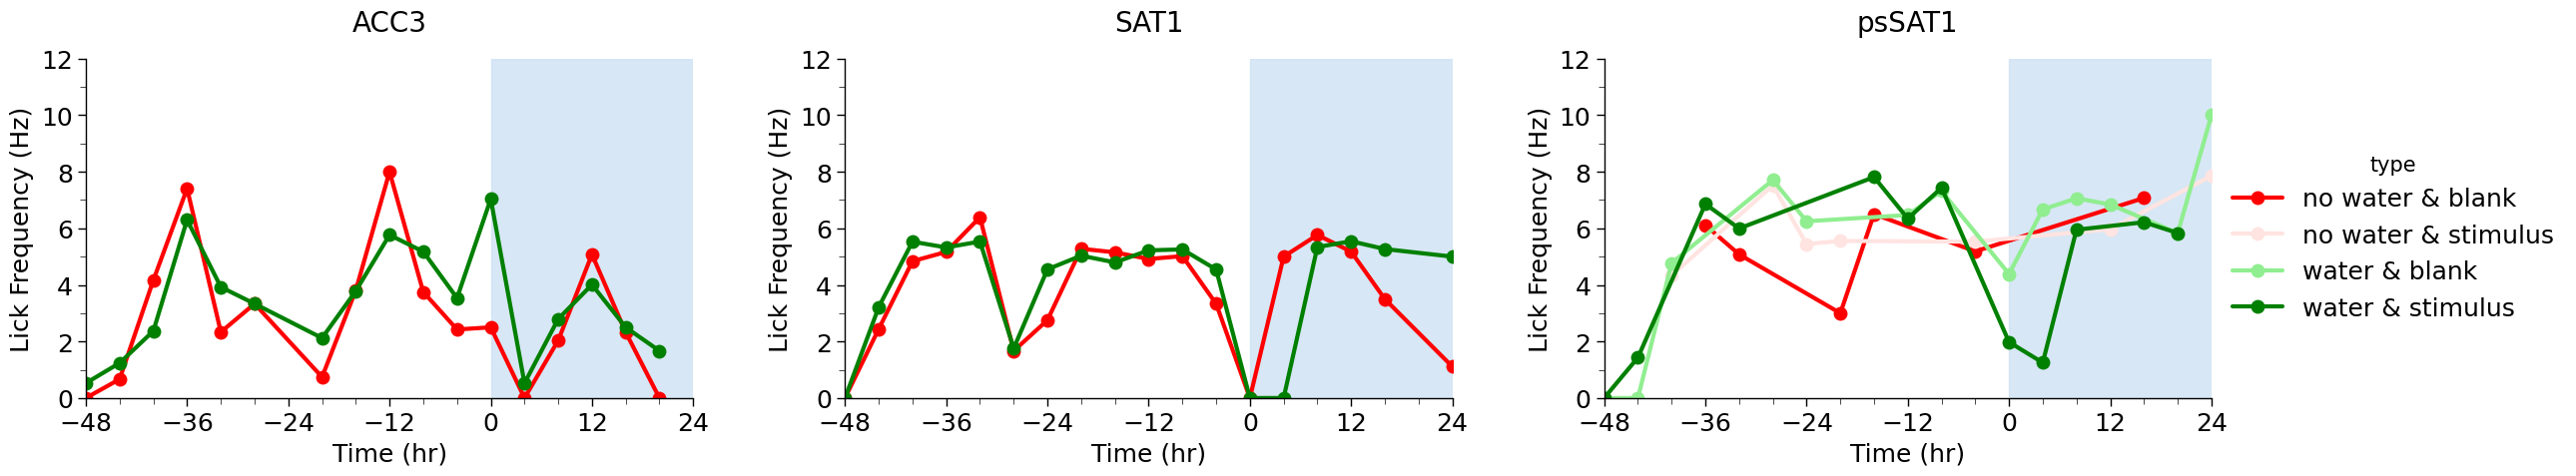

In [27]:
ps_ordr = ["no water & blank", "no water & stimulus", 
        "water & blank", "water & stimulus"]
ps_p = ["red", "mistyrose", "lightgreen", "green"]

plot_ant_lickfreq(ant_mean_statistics, hue="type", palette=ps_p, hue_order=ps_ordr)

Performance (L<sub>stim</sub> - L<sub>blank</sub>) as a line plot and a bar plot

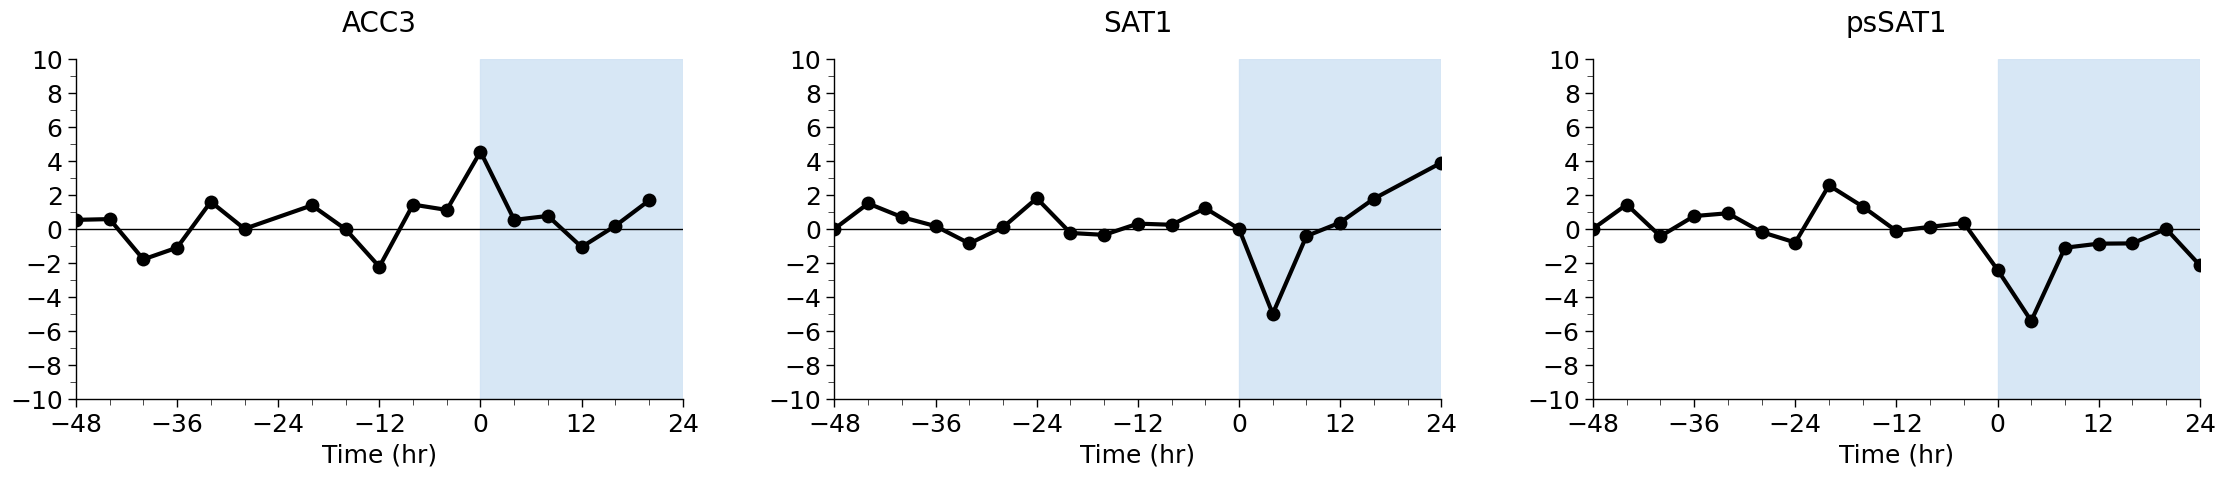

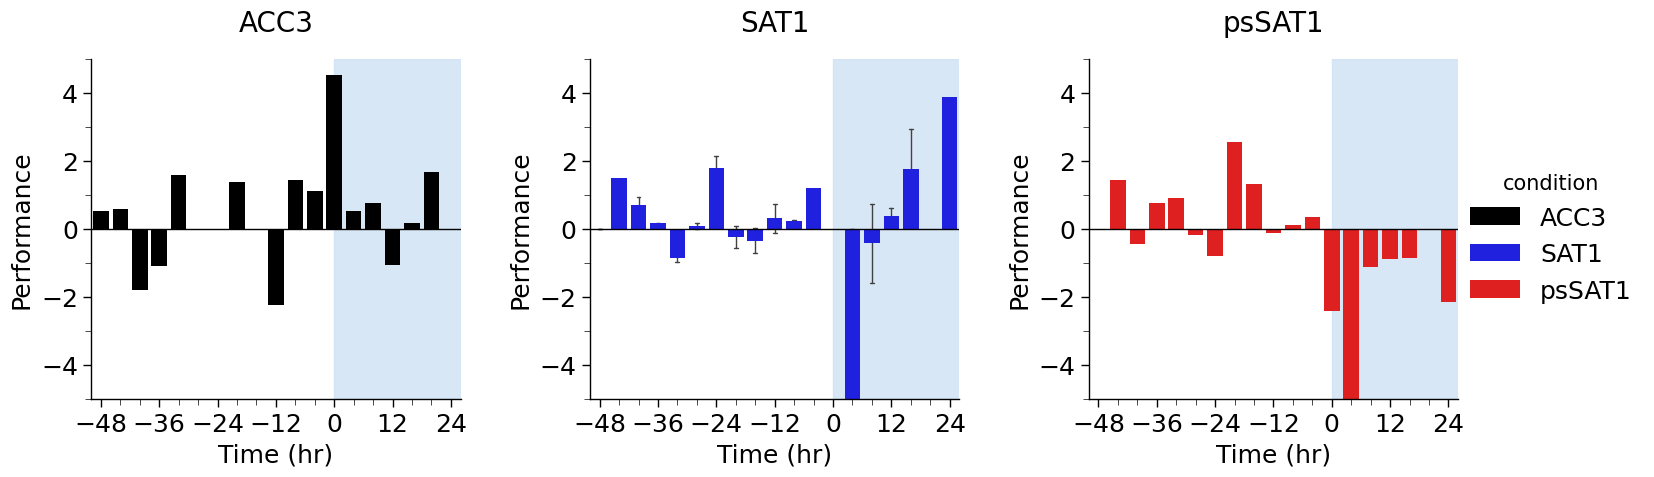

In [28]:
plot_ant_perf(ant_perf)

# using a palette to color different conditions
p = ["k", "b", "r"]
ylim=[-5, 5]
plot_ant_perf_bar(ant_perf, ylim=ylim, hue="condition", palette=p)

Number of trials by day and by time bin

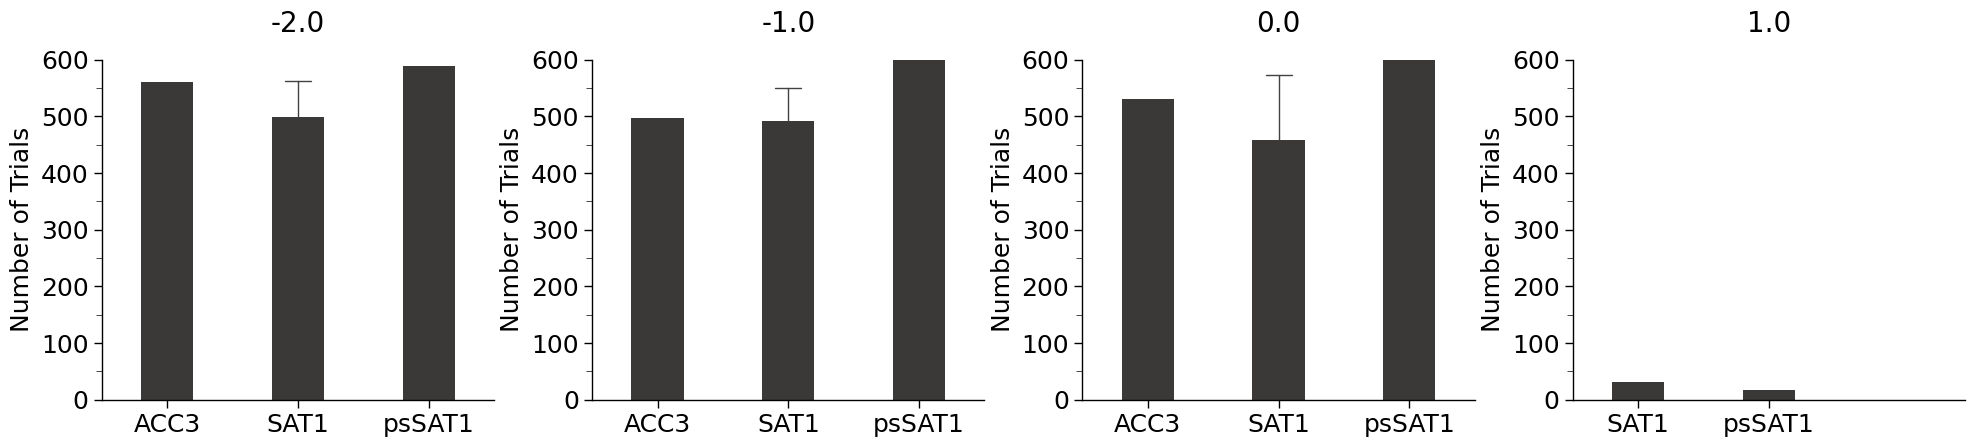

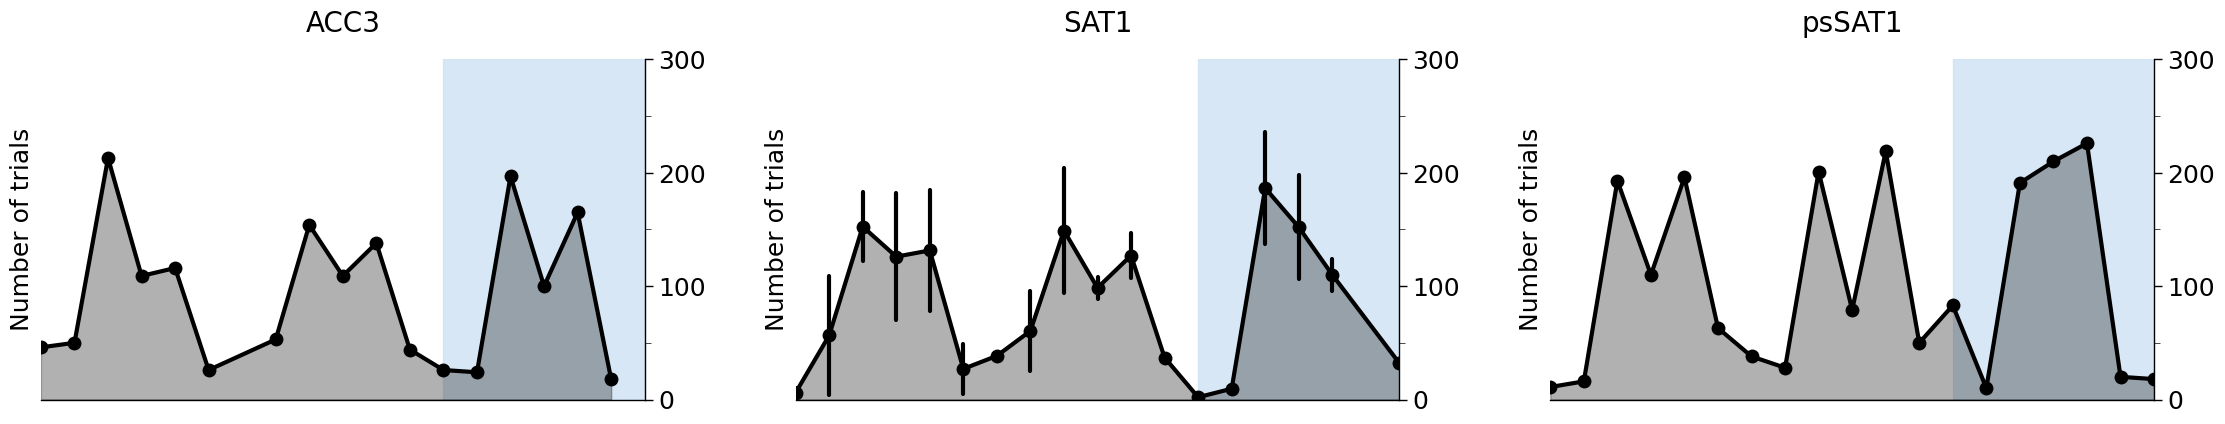

In [29]:
plot_trial_bar(total_by_day)
plot_trial_hr(total_by_hour, xlim=[-48, 24])

Last 20% of trials 

array(['ACC3', 'SAT1', 'psSAT1'], dtype=object)

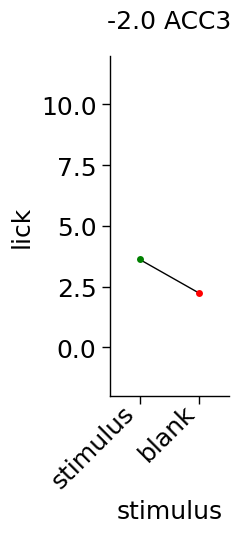

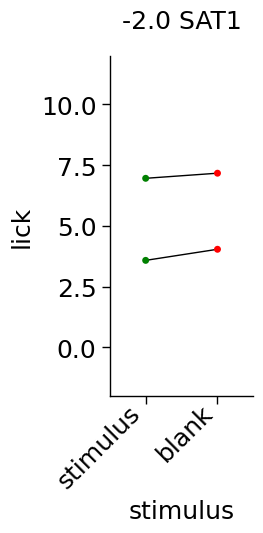

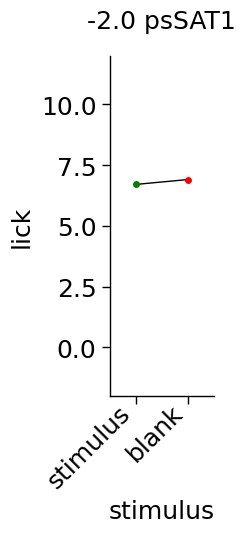

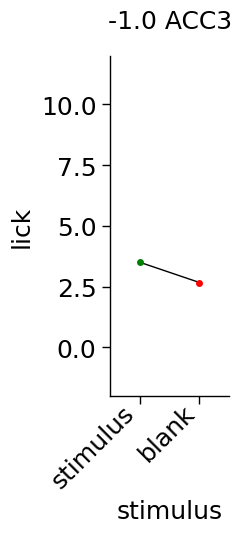

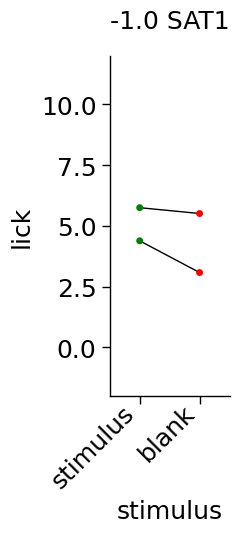

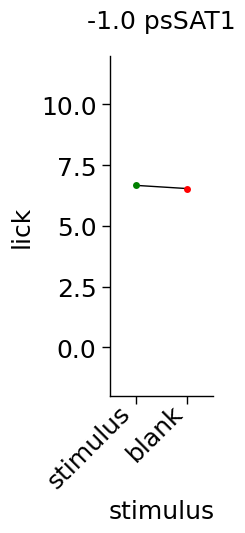

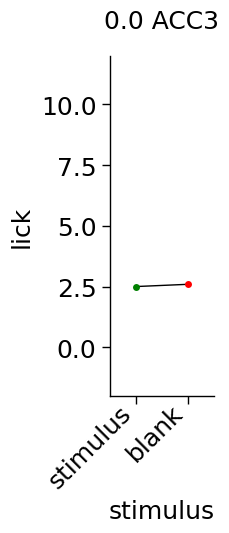

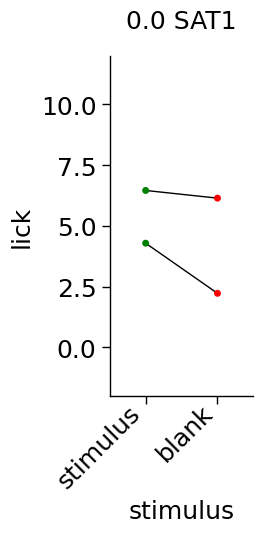

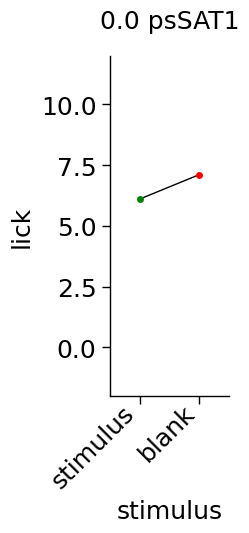

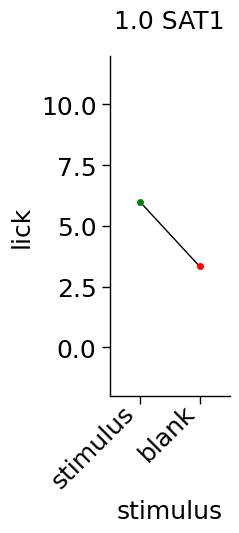

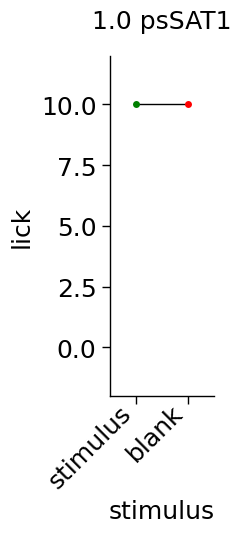

In [37]:
for day in nthpart_lickfreq["Day"].unique():
        x=[1, 2]
        i=0
        conds = nthpart_lickfreq["condition"].unique()
        conds.sort()
        dayfilt = nthpart_lickfreq[nthpart_lickfreq["Day"] == day]
        for c in conds:
                condfilt = dayfilt[dayfilt["condition"]==c]
                if not condfilt.empty:
                    g = sns.catplot(condfilt, y="lick",x="stimulus", order=["stimulus", "blank"],kind="strip", 
                            hue="stimulus", palette=["green", "red"], 
                            hue_order=["stimulus", "blank"],
                            col="condition", jitter=False, aspect=0.5, legend=False)
                    segs = []
                    for a in condfilt["animal"].unique():
                        anfilt = condfilt[condfilt["animal"] == a]
                        bl = anfilt[anfilt["stimulus"] == "blank"]["lick"].reset_index(drop=True)
                        st = anfilt[anfilt["stimulus"] == "stimulus"]["lick"].reset_index(drop=True)
                        if (len(bl) != 0) & (len(st) != 0):
                            add=[[0, st[0]], [1,bl[0]]]
                        segs.append(add)
                    linesegs = LineCollection(segs,color='k', lw=1)
                    g.axes_dict[c].add_collection(linesegs)
                    g.axes_dict[c].set_ylim([-2, 12])
                    g.axes_dict[c].set_title(f"{day} {c}")
                    g.axes_dict[c].tick_params(axis='x', pad=-3)
                    g.axes_dict[c].set_xticklabels(g.axes_dict[c].get_xticklabels(), rotation=45, ha="right")
                    i+=1
        #g.figure.suptitle(day, y=1.05)
conds


Number of trials by trial type

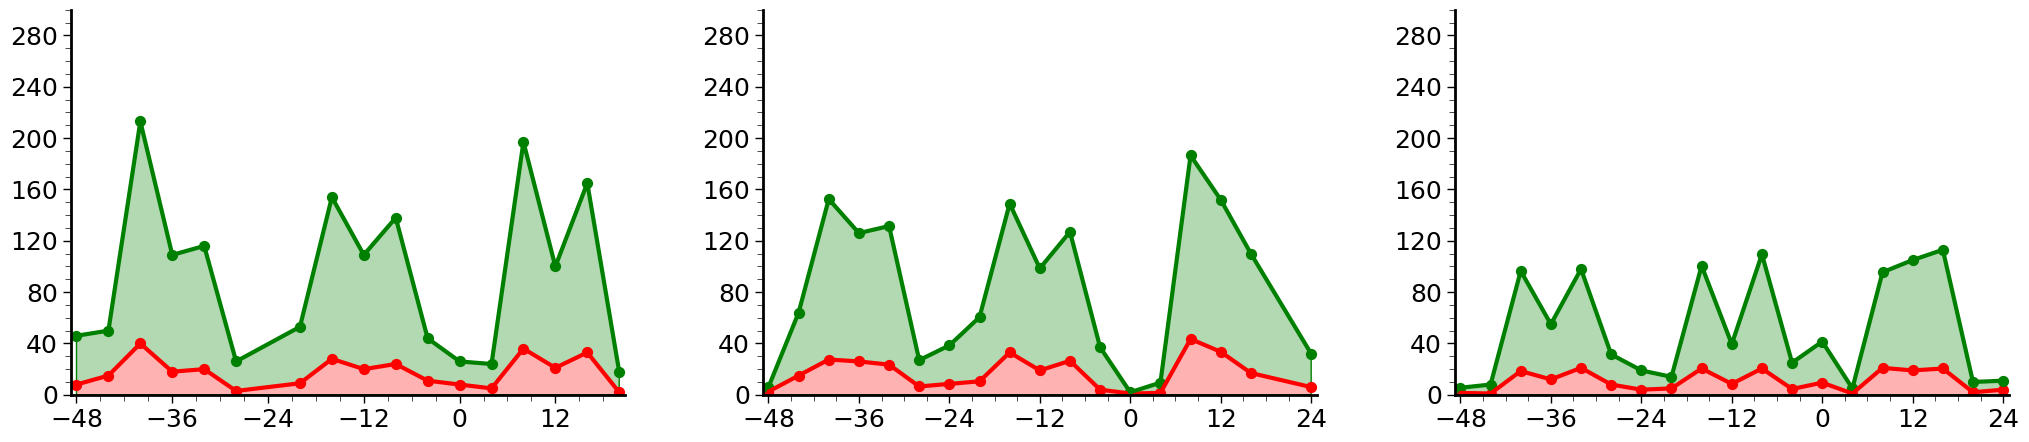

In [38]:
# number of stimulus and blank trials as stacked plot (average but no error bars)
cond = (counts["Time (hr)"] <= 120) & (counts["Time (hr)"] >= -48)
avg_counts = counts[cond]
avg_counts = avg_counts.groupby(["condition", "Time (hr)", "stimulus"])["trial no"].mean().reset_index()

conds = avg_counts["condition"].unique()
g, axs = plt.subplots(1, len(conds), figsize=(25,5))

ylims = [0, 300]
ymax = ylims[1]

for i in range(len(conds)):
    lab = avg_counts[avg_counts["condition"] == conds[i]]["stimulus"].unique()
    x = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["Time (hr)"]
    axs[i].spines[["top", "right"]].set_visible(False)
    y1 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[0])]["trial no"].reset_index(drop=True)
    y2 = avg_counts[(avg_counts["condition"] == conds[i]) & (avg_counts["stimulus"] == lab[1])]["trial no"].reset_index(drop=True)
    axs[i].stackplot(x, y1, y2, labels=lab, colors=['#FFB2B2','#B2D9B2'], alpha=1, edgecolor=["green", "red"])
    axs[i].plot(x, y1, color="red")
    axs[i].scatter(x, y1, color="red", s=50)
    axs[i].plot(x, (y1 + y2),color="green")
    axs[i].scatter(x, (y1 + y2), color="green",s=50)    
    ylabel="Number of trials"
    axs[i].set_ylim(ylims)
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(12))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(40))
    axs[i].xaxis.set_minor_locator(ticker.MultipleLocator(3))
    axs[i].yaxis.set_minor_locator(ticker.MultipleLocator(10))
    axs[i].spines[["bottom", "left"]].set(lw=2)
g.subplots_adjust(wspace=0.25)

### 2.1.4 Statistical Tests

Total number of trials between groups (should not be significantly different)

t-test if two conditions, ANOVA otherwise

In [39]:
res = []
for day in total_by_day["Day"].unique(): 
    tt_separated = []
    for c in total_by_day["condition"].unique():
        tt_separated.append(total_by_day[(total_by_day["Day"] == day) & (total_by_day["condition"] == c)]["trial no"])
    if len(total_by_day["condition"].unique()) == 2:
        res.append(stats.ttest_ind(*tt_separated, equal_var=False))
    elif len(total_by_day["condition"].unique()) > 2:
        res.append(stats.f_oneway(*tt_separated))
pd.DataFrame(res, columns=["statistic", "pvalue"], index=total_by_day["Day"].unique())

statistic    pvalue
-2.0   0.386912  0.750835
-1.0   0.817832  0.615963
 0.0   1.020045  0.573531
 1.0        NaN       NaN

Total number of trials across days (should not be significantly different)

t-test if only 2 days, ANOVA otherwise

In [40]:
res = []
for c in total_by_day["condition"].unique(): 
    tt_separated = []
    tmp = total_by_day[total_by_day["condition"] == c]
    for day in tmp["Day"].unique():
        tt_separated.append(total_by_day[(total_by_day["Day"] == day) & (total_by_day["condition"] == c)]["trial no"])
    if len(total_by_day["Day"].unique()) == 2:
        res.append(stats.ttest_ind(*tt_separated, equal_var=False))
    elif len(total_by_day["Day"].unique()) > 2:
        res.append(stats.f_oneway(*tt_separated))
        
pd.DataFrame(res, columns=["statistic", "pvalue"], index=total_by_day["condition"].unique())

statistic    pvalue
ACC3          NaN       NaN
SAT1     4.356689  0.128987
psSAT1        NaN       NaN

Last 20% of trials for all days of SAT

In [45]:
# TODO: incorrect because of incorrect aggregation
res = []

stimcond = nthpart_lickfreq["stimulus"] == "stimulus"
blankcond = nthpart_lickfreq["stimulus"] == "blank"

days = nthpart_lickfreq["Day"].unique()
days = days[days >= 0]

conds = nthpart_lickfreq["condition"].unique()

ind = nthpart_lickfreq[nthpart_lickfreq["Day"] >= 0][["Day", "condition"]].apply(tuple, axis=1).unique()

for day, c in ind:
    daycond = nthpart_lickfreq["Day"] == day
    ccond = nthpart_lickfreq["condition"] == c
    stim = nthpart_lickfreq[stimcond & daycond & ccond]["lick"]
    blank = nthpart_lickfreq[blankcond & daycond & ccond]["lick"]
    res.append(stats.ttest_ind(stim, blank, equal_var=False))

pd.DataFrame(res, columns=["statistic", "pvalue"], index=pd.Series(ind).apply(lambda x: x[1] + ", " + str(x[0])))

statistic    pvalue
ACC3, 0.0          NaN       NaN
SAT1, 0.0     0.531194  0.661003
SAT1, 1.0          NaN       NaN
psSAT1, 0.0        NaN       NaN
psSAT1, 1.0        NaN       NaN

## 2.2 Lick frequency for entire trial


If `freq_window` is not `None` data will be averaged with a rolling window of the
given length. Data will then be averaged into discrete time bins the legnth of
`freq_bin`. If `freq_bin` is the rate at which data is sampled (every 100ms),
then instentaneous lick frequency will be averaged across animals. 

Parameters

In [46]:
freq_window = None # milliseconds, length of rolling window
freq_bin = 100 # milliseconds, length of discrete time bin

### 2.2.1 Analysis

In [53]:
mins["min_trials"] = 10 # minimum number of trials in a bin to keep
mins["min_blank"] = 1 # minimum number of water trials
mins["min_stimulus"] = 1 # minimum number of water trials

keys["millis bin"] = "puff delta"
keys["time bin"] = "delta"
time_bin = 4*60 # minutes

data = full_lickfreq(df, freq_window, freq_bin, time_bin, keys, keep, values)

flkeep = keep + ["Time (hr)", "delta", "Day", "day_delta", "puff delta", "Time (ms)"]


Index(['condition', 'animal', 'delta', 'stimulus', 'water', 'trial no', 'Age',
       'Sex', 'Strain', 'acc', 'Cage', 'type', 'Time (hr)', 'Day', 'day_delta',
       'puff delta', 'Time (ms)'],
      dtype='object')


In [ ]:
data_filtered = drop_group(data, mins, keys, "trial no", index, flkeep)
means, flcounts, perf = agg(data_filtered, keys, index, flkeep, values)
fl_totals_by_day = sum_trials(flcounts, index + ["Day"],keep, "trial no")
fl_totals_by_hour = sum_trials(flcounts, index + ["Time (hr)"],keep, "trial no")

### 2.2.2 Plotting

Instentaneous licking frequency for stimulus and blank trials for entire trial

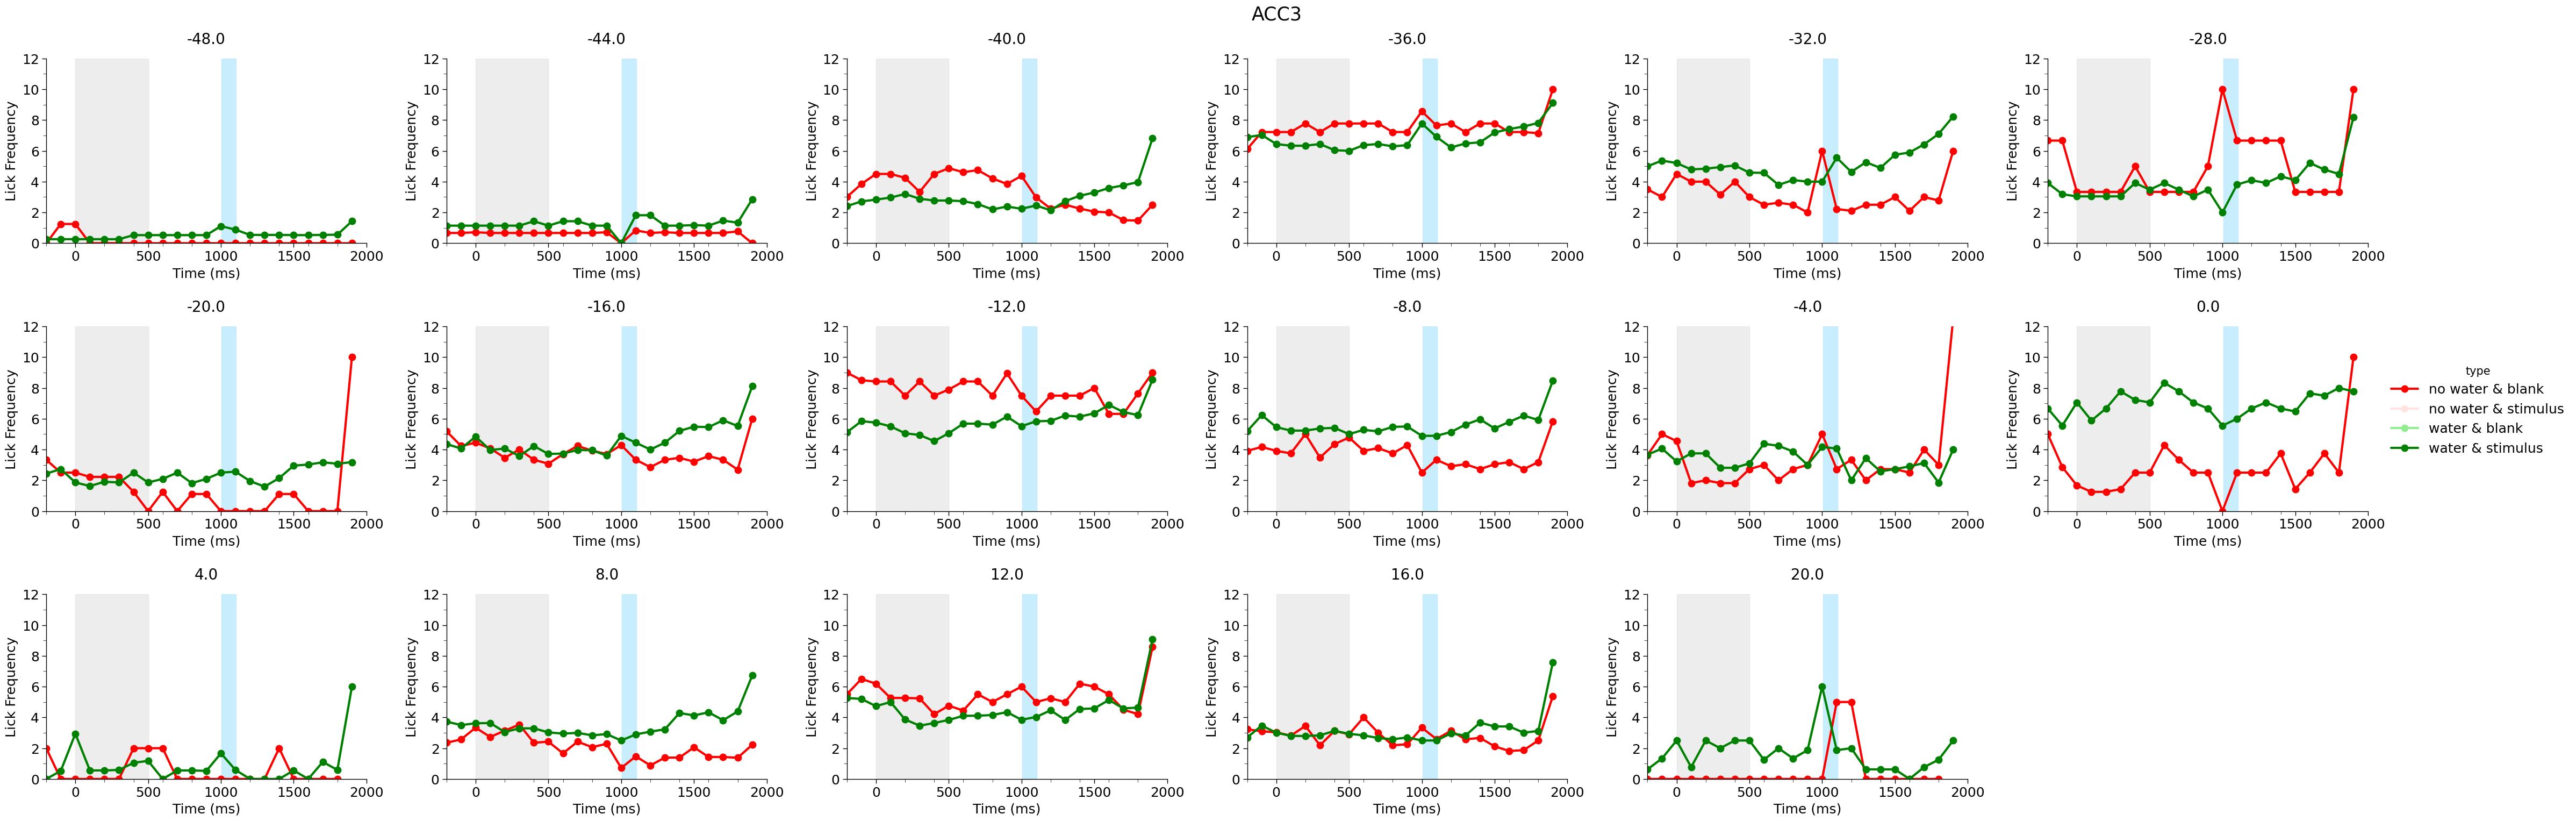

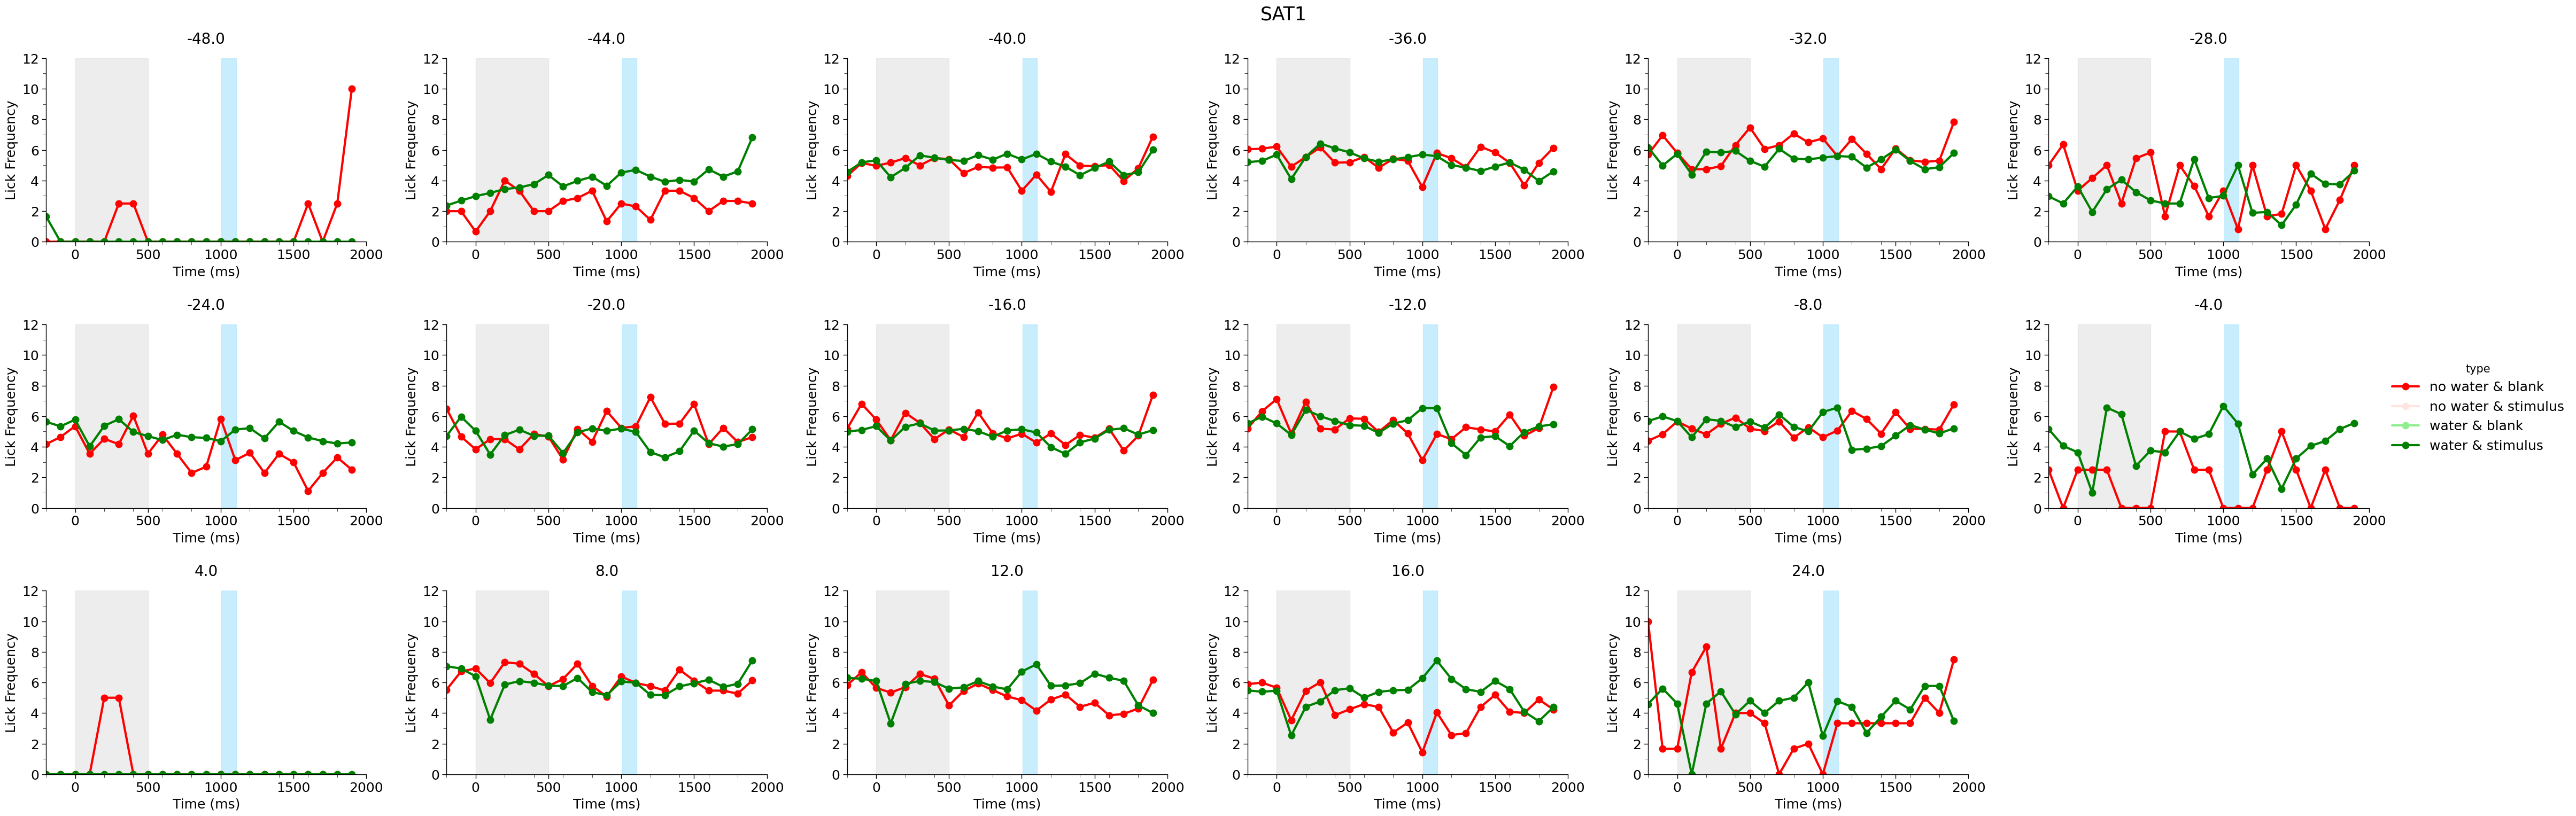

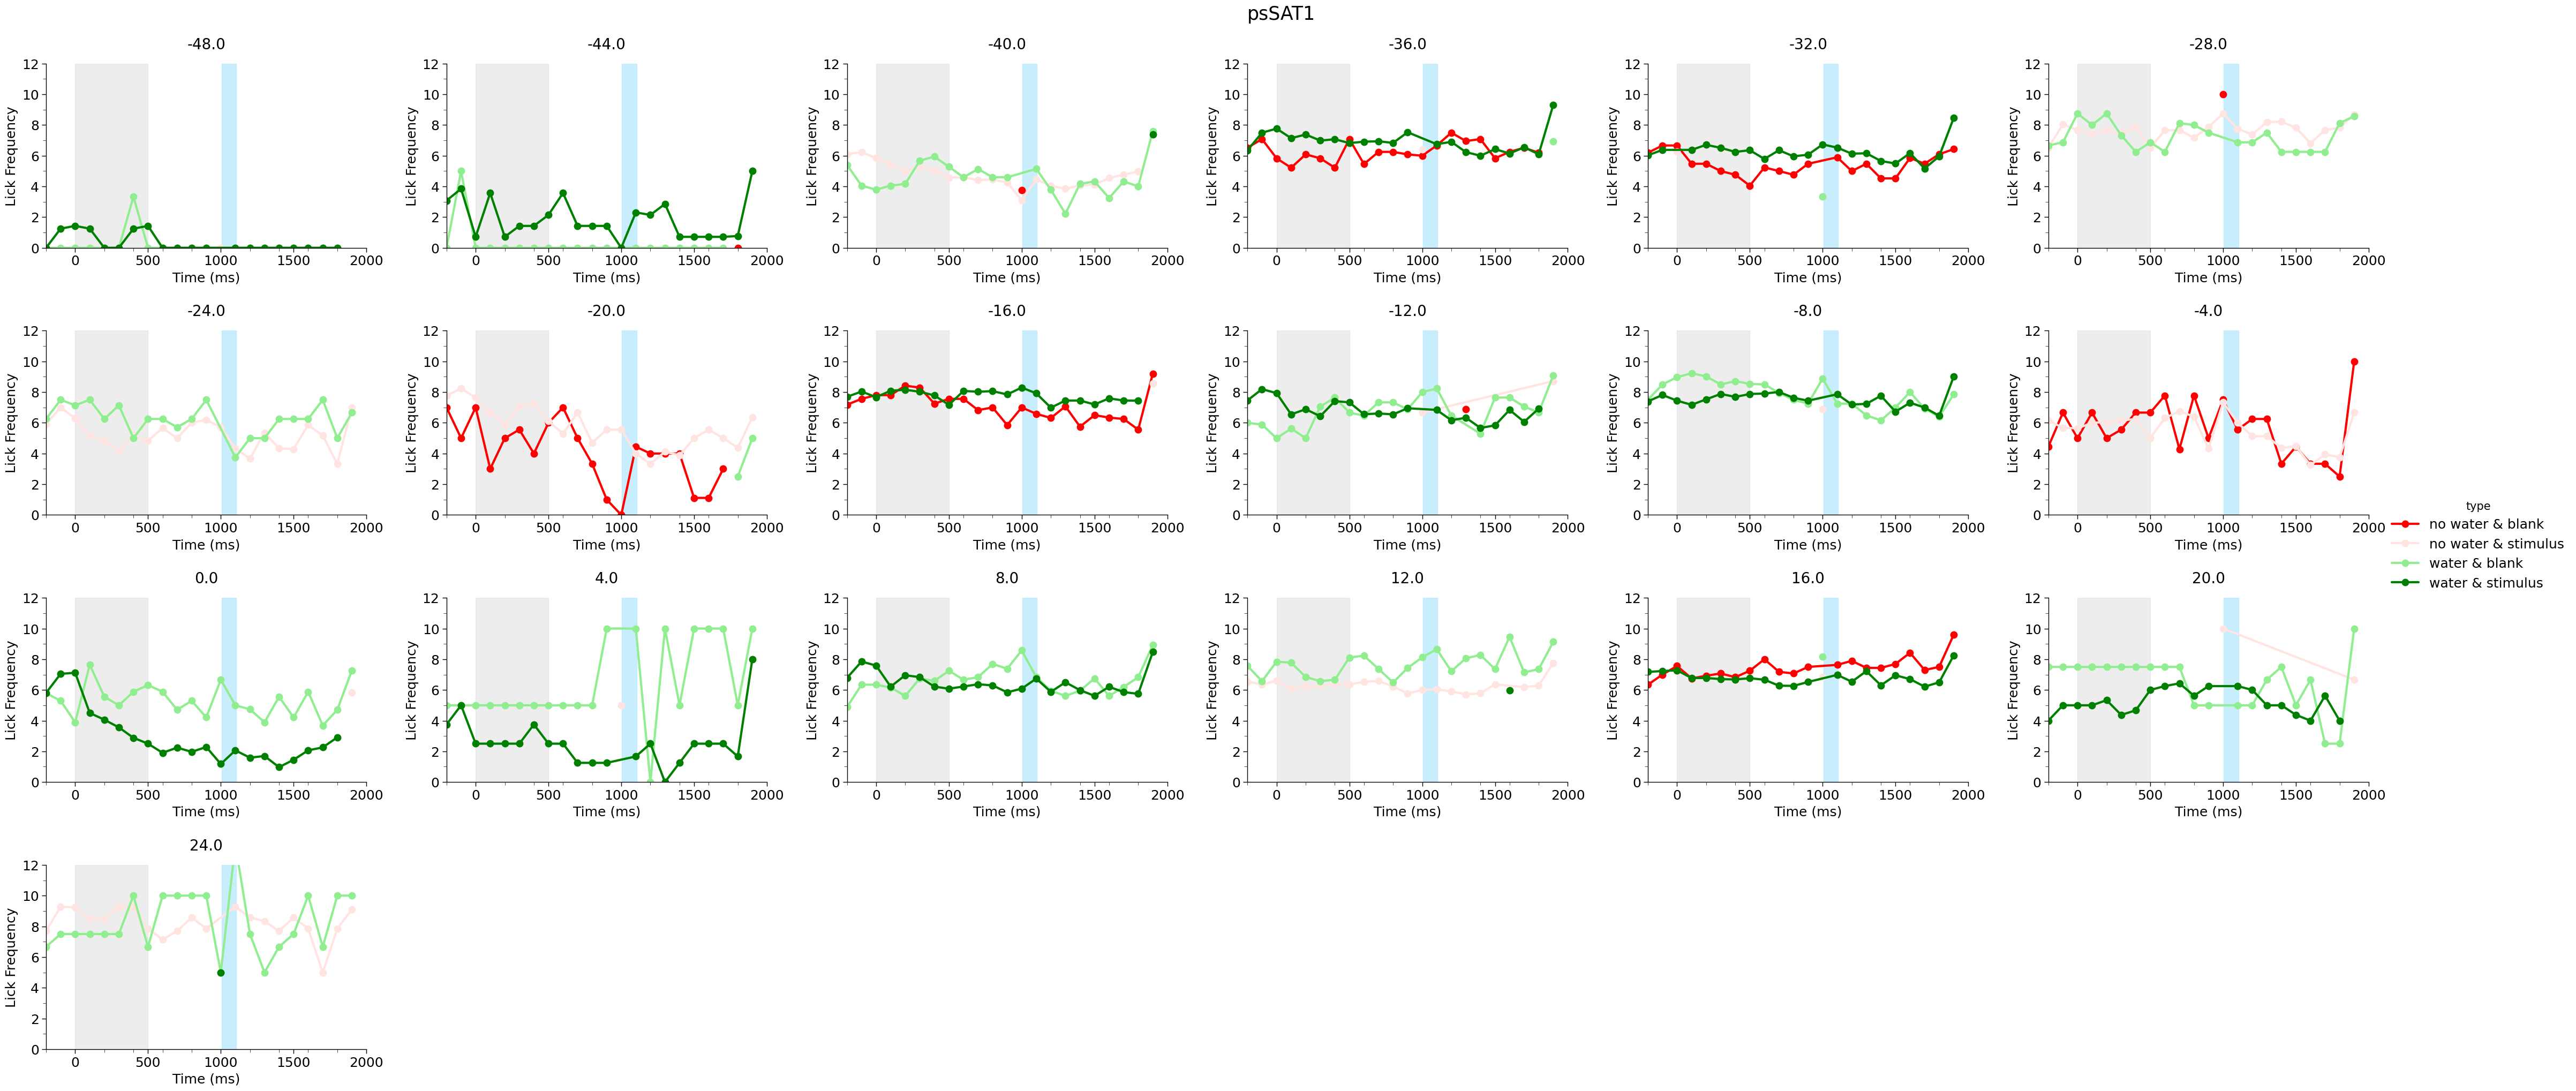

In [54]:
for condition in means["condition"].unique():
    plot_data = means[means["condition"] == condition]
    plot_lickfreq(plot_data, suptitle=condition, hue="type", hue_order=ps_ordr, palette=ps_p)

Performance (L<sub>stim</sub> - L<sub>blank</sub>) for entire trial, comparing
timebins together across groups

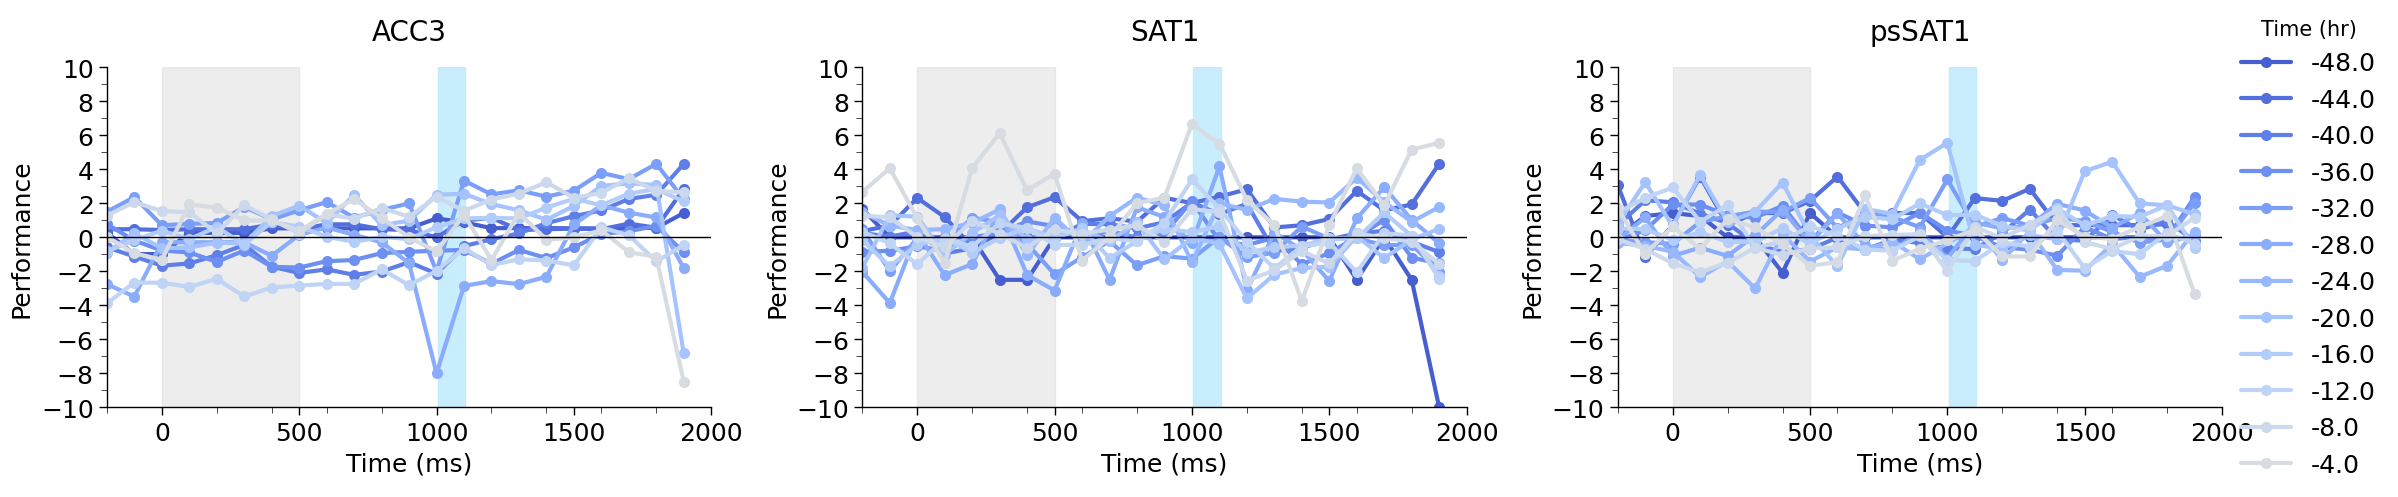

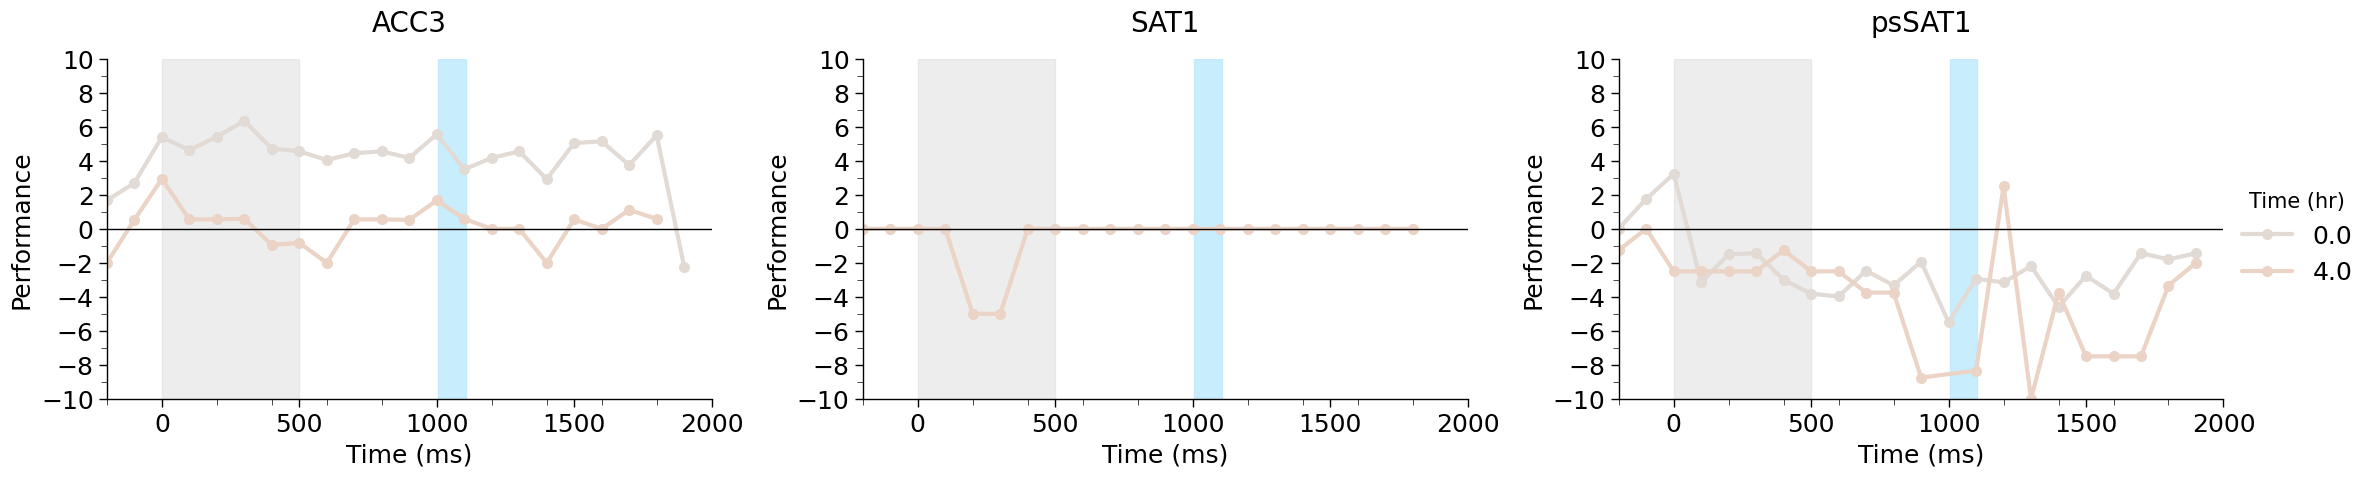

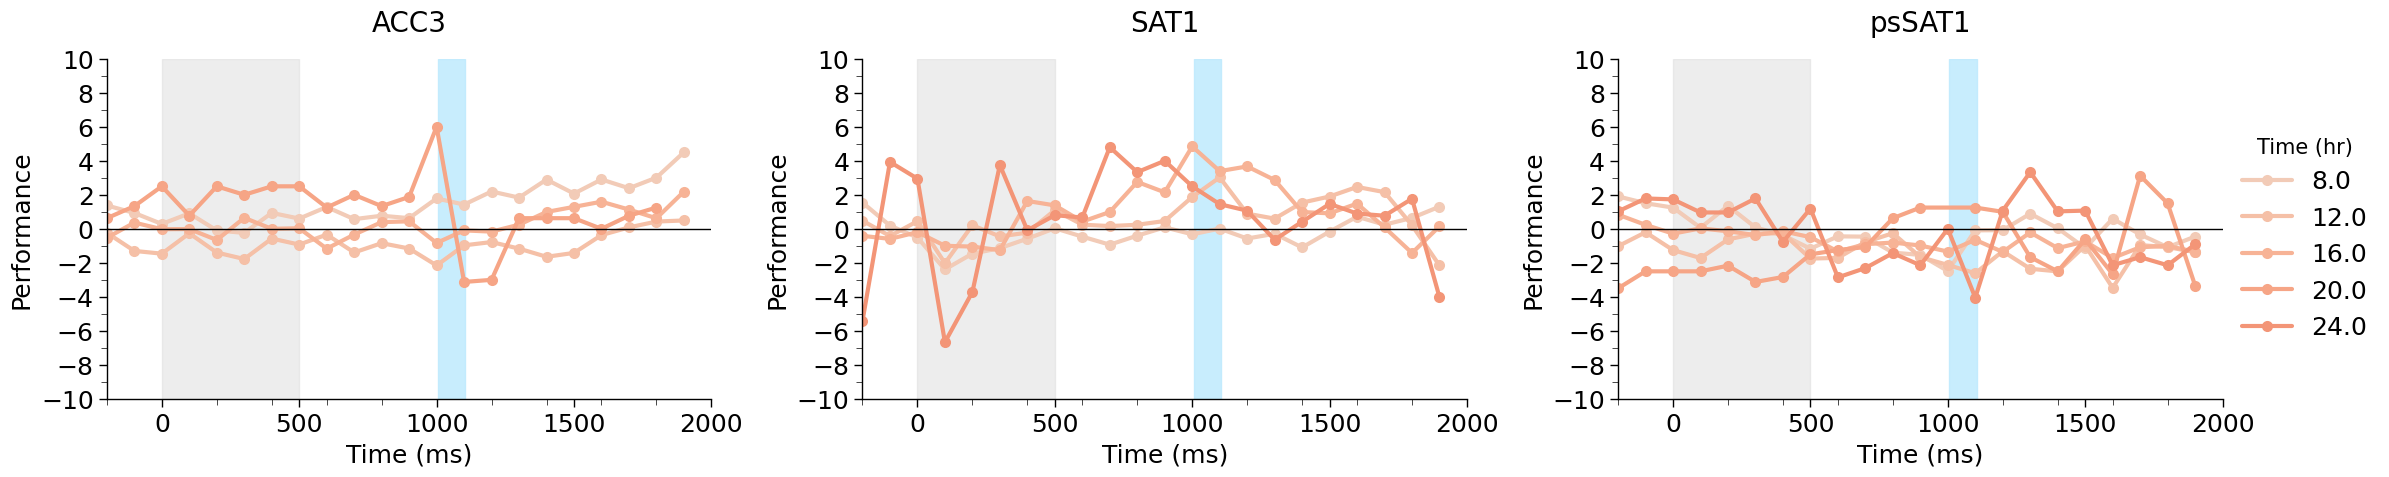

In [55]:
acc = ( (perf["Time (hr)"] < 0) )
early = ( (perf["Time (hr)"] < 8) & (perf["Time (hr)"] >= 0) )
late = ( (perf["Time (hr)"] >= 8) )

# ensures palette is centered around 0
num_bins = len(perf[acc]["Time (hr)"].unique()) * 2
pl = sns.color_palette("coolwarm", n_colors=num_bins)

# 12 4h bins in ACC48 
plot_perf(perf[acc], palette=pl[0:12],ms=8)

# first 2 SAT timebins (SAT8)
plot_perf(perf[early], palette=pl[12:14],ms=8)

# rest of SAT
plot_perf(perf[late], palette=pl[14:],ms=8)


Performance (L<sub>stim</sub> - L<sub>blank</sub>) for entire trial, comparing
groups together across timebins

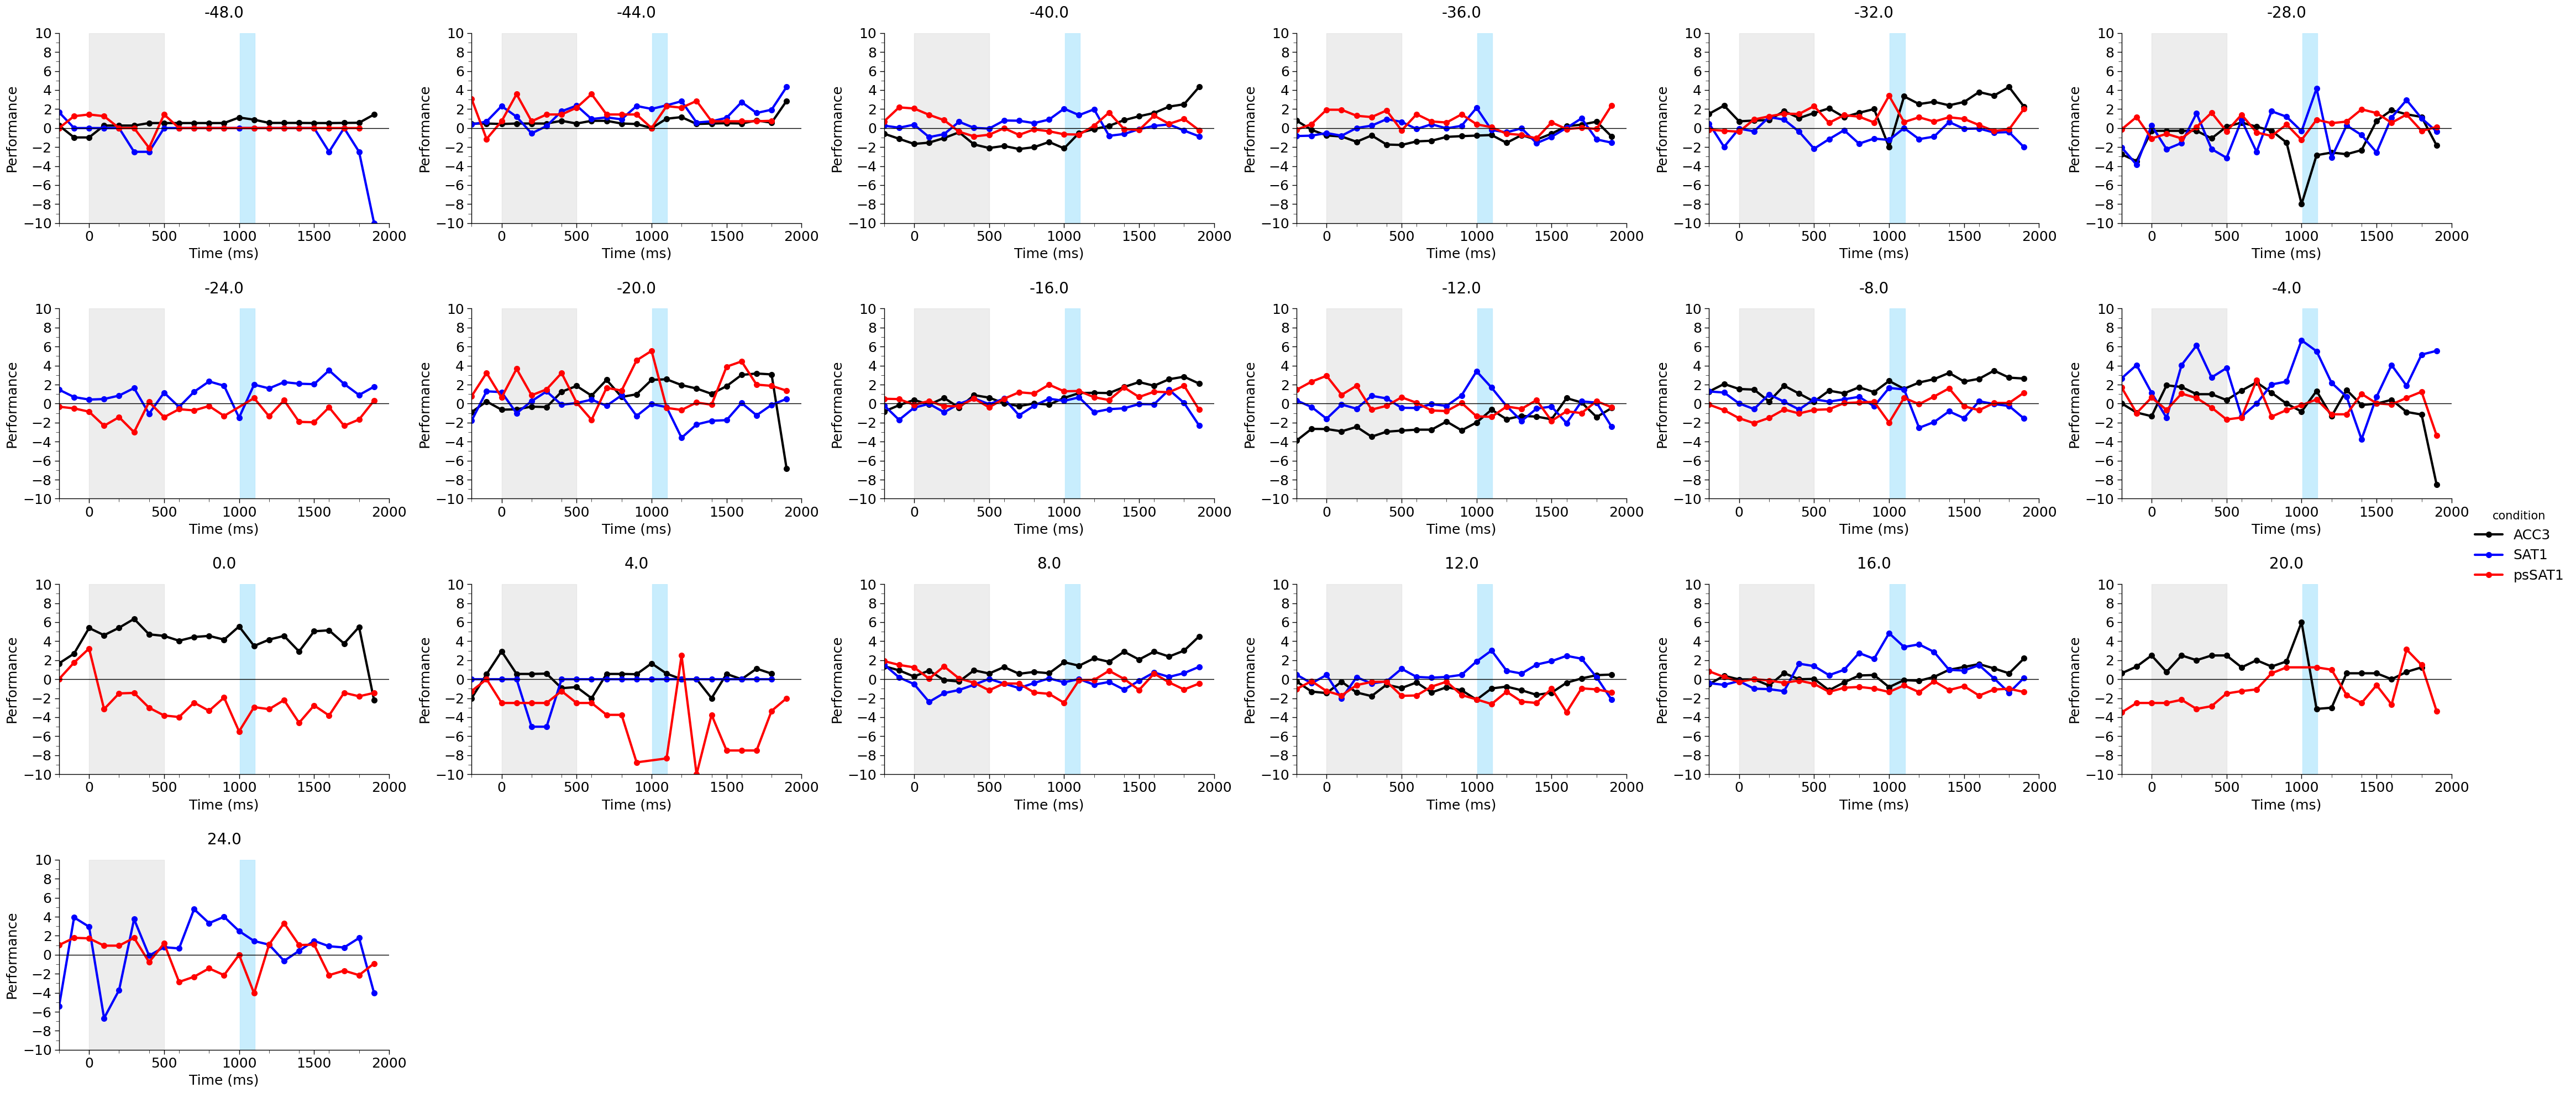

In [56]:
p = ["k", "b", "r"]
plot_perf(perf, col="Time (hr)", hue="condition", ms=8, palette=p, col_wrap=6)

# 3. Raster of trials (one animal)

Text(0.5, 0, 'Time (min)')

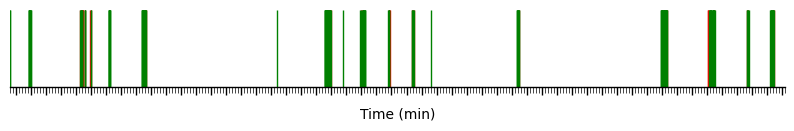

In [57]:
# raster for one animal
a = data[(data["animal"] == "LYO1")]
a = a.groupby("trial no").first().reset_index()
start = datetime.datetime(year=2022, month=3, day=5, hour=19, minute=53)
end = datetime.datetime(year=2022, month=3, day=6, hour=0, minute=11)
a = a[(a["timestamp"] >= start) & (a["timestamp"] <= end)].reset_index(drop=True)
a["relative time"] = a["timestamp"] - a["timestamp"][0]
a = time_to_float(a, "relative time", "relative time", "ms")
a["relative time"] = a["relative time"]/(1000.*60.)
gps = []
for gname, gp in a.groupby(["stimulus"]):
    gps.append(gp["timestamp"])

fig, ax = plt.subplots(1, 1, figsize=(10,1))
c = ["red", "green"]

lo = 0
lw = 1
ll = 1

ax.eventplot(positions=gps, colors=c, lineoffsets=lo, linewidths=lw, linelengths=ll) 
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))  
ax.xaxis.set_major_formatter(ticker.NullFormatter())

ax.set_ylim([-0.5,0.5])
ax.set_xlim([start,end])

ax.spines[["left", "right", "top"]].set(visible=False)
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.set_xlabel("Time (min)", fontsize='10')



# 4. Output Results 

This will overwrite any previous output in the same folder, so make sure to 
move files or change the output directory if running the code multiple times.

### 4.1 Aggregate data

In [58]:
output_dir = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\mouse_analysis\\full_trial_analysis\\example_output\\'
cols = ["condition", "animal", "stimulus", "Time (hr)", "Time (ms)", "lick"]
means.to_excel(f'{output_dir}lick_frequency.xlsx', columns=cols, index=False)

cols = ["condition", "animal", "Time (hr)", "stimulus", "trial no"]
counts.to_excel(f'{output_dir}trial_counts.xlsx', columns=cols, index=False)

cols = ["condition", "animal", "Time (hr)", "Time (ms)", "lick"]
perf.to_excel(f'{output_dir}performance.xlsx', columns=cols, index=False)

with open(f'{output_dir}parameters.txt', mode='w') as f:
    out = f'''csv_directory = {csv_directory}
metadata_file = {metadata_file}


time_bin = {time_bin} minutes
freq_window = {freq_window} milliseconds, length of rolling window
freq_bin = {freq_bin} milliseconds, length of discrete time bin

min_trials = {min_trials} minimum number of trials in a bin to keep
min_water_trials = {min_water_trials} minimum number of water trials
min_blank_trials = {min_blank_trials} minimum number of water trials
'''
    f.write(out)

### 4.2 Raw lick frequency data

Takes a long time to run due to large number of samples 
(there are ~40k rows per animal)

In [ ]:
# raw data has too many lines to output to excel
# large number of samples means this takes a long time (~6s for 4 animals)
data.to_csv(f'{output_dir}rawlickfrequency.csv', index=False)

# 5. Pipeline description

__Pipeline:__

>```
>raw data (csv) ------------|    loader.py                                                     lickfreq_analysis                                            
>                            |------------------> formatted data - many animals (dataframe) ---------------------------> trial-level analysis(dataframe)
>metadata (excel) ----------|
>
>                                     aggregate_analysis   |---> trial number counts by timebin and condition (dataframe) ---|
>trial-level analysis (dataframe) ------------------------|---> mean lick frequency by timebin (dataframe) -----------------|---> plots
>                                                          |---> performance by timebin (dataframe) -------------------------|
>```

***

__Formats__

*raw data*

>time (ms), poke, lick, condition code, delay, stimulus

- time measured from start of file
- poke in {0, 1}
- lick in {0, 2}
- condition code in {3, 4, 5, 7, 9}
    - 3 = delay
    - 4 = air delivery
    - 5 = water delivery
    - 7 = after water delivery
    - 9 = blank
- 200 <= delay <= 800
- stimulus in {0, 1}
    - stimulus not present in SAT code
    - stimulus present and relevant in pseudo code

*metadata*

- excel
- must include 'Animal ID' (3 letter + number animal code)
- must include 'acc' (time of acclimation in days)
- other example columns: age, sex, strain

*formatted data*

>timestamp, poke, lick, condition code, delay, trial no, water, stimulus, animal, condition, metadata

- metadata can be multiple columns

*trial-level analysis*
> condition, animal, trial no, puff delta, trial start, timestamp, metadata, stimulus, water, lick, poke, delta, time (hr), time (ms)

- puff delta is equivalent to time (ms)
    - represents timestamp normalized to air delivery
    - puff delta is timedelta and time (ms) is float
- trial start represents timebin as timestamp
- delta is equivalent to time (hr)
    - represents timebin normalized to start of stat
    - delta is timedelta and time (hr) is float
- metadata can be multiple columns
- lick and poke now represent frequencys aggregated based on given window size

